# Document Redaction with Azure AI Document Intelligence layout analysis and Azure OpenAI GPT-4o

This sample demonstrates how to use Azure AI Document Intelligence and Azure OpenAI GPT models to redact any required texts from a document. 

![Data Redaction](../../../images/redaction-document-intelligence-openai.png)

This is achieved by the following process:

- Analyze a document using Azure AI Document Intelligence's `prebuilt-layout` model to perform advanced OCR analysis, extracting per-page text and words (including bounding boxes).
- For each page:
  - Construct a system prompt that defines the instruction for locating words to redact.
  - Construct a user prompt that includes specific details for what to redact, and the page analysis result.
  - Use the Azure OpenAI chat completions API with the GPT-4o model to generate a structured output from the content that details the words to redact from the document page.
  - Redact over each word to remove from the document page using the bounding boxes provided by the analysis result.
- Save the redacted document to an output file.

## Use Cases

- Pre-procesing of documents for compliance with data privacy regulations ahead of downstream processing.
- Need for customized redaction rules based on your specific requirements using natural language instructions.

## Objectives

By the end of this sample, you will have learned how to:

- Perform OCR analysis on a document using Azure AI Document Intelligence.
- Use prompt engineering techniques to instruct GPT-4o to locate specific words to redact from the OCR analysis result.
- Use the [Structured Outputs feature](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs?tabs=python-secure) to generate a consistent response from Azure OpenAI's GPT-4o model.
- Redact words from a document using the results from the GPT-4o model.
- Save the redacted document to an output file.

## Useful Tips

- Combine this technique with a [page classification](../classification/README.md) approach to reduce the number of pages to redact to only those that match your criteria for redaction.
- You can also combine this technique with a post-processing [document data extraction](../extraction/README.md) approach to extract specific information from the document after redaction.

## Setup

### Import modules

This sample takes advantage of the following .NET dependencies:

- **Azure.AI.DocumentIntelligence** to interface with the Azure AI Document Intelligence API for analyzing documents.
- **Azure.AI.OpenAI** to interface with the Azure OpenAI chat completions API to generate structured redaction outputs using the GPT-4o model.
- **Azure.Identity** to securely authenticate with deployed Azure Services using Microsoft Entra ID credentials.
- **pdf2image-dotnet** for converting a PDF file into a set of images per page.
- **SkiaSharp** for manipulating the page images to redact words.

The following local components are also used:

- [**Redaction**](../../modules/samples/models/Redaction.csx) to provide the expected structured output JSON schema for redactions in documents.
- [**OpenAIStructuredOutputsHelpers**](../../modules/samples/helpers/OpenAIStructuredOutputsHelpers.csx) to generate structured outputs from the OpenAI API and provide parsing functions for the response output.
- [**AccuracyEvaluator**](../../modules/samples/evaluation/AccuracyEvaluator.csx) to evaluate the output of the redaction process with expected results.
- [**OpenAIConfidence**](../../modules/samples/confidence/OpenAIConfidence.csx) to calculate the confidence of the redaction process based on the `logprobs` response from the OpenAI API request using the `Microsoft.ML.Tokenizers` and `Microsoft.ML.Tokenizers.Data.O200kBase` libraries (the latter is required for tokenizers used for the GPT-4o model).
- [**DocumentProcessingResult**](../../modules/samples/models/DocumentProcessingResult.csx) to store the results of the redaction process as a file.
- [**AppSettings**](../../modules/samples/AppSettings.csx) to access environment variables from the `.env` file.

In [1]:
#r "nuget: Azure.Identity, 1.13.2"
#r "nuget: Azure.AI.OpenAI, 2.1.0"
#r "nuget: Azure.AI.DocumentIntelligence, 1.0.0"
#r "nuget: DotNetEnv, 3.1.1"
#r "nuget: Microsoft.ML.Tokenizers, 1.0.2"
#r "nuget: Microsoft.ML.Tokenizers.Data.O200kBase, 1.0.2"
#r "nuget: pdf2image-dotnet, 1.0.0"
#r "nuget: SkiaSharp, 3.116.1"
#r "nuget: SkiaSharp.NativeAssets.Linux, 3.116.1"

#!import ../modules/samples/AppSettings.csx
#!import ../modules/samples/helpers/OpenAIStructuredOutputsHelpers.csx
#!import ../modules/samples/helpers/StopwatchContext.csx
#!import ../modules/samples/models/Redaction.csx
#!import ../modules/samples/models/DocumentProcessingResult.csx
#!import ../modules/samples/confidence/OpenAIConfidence.csx

using System;
using System.IO;
using System.Text.Json;
using System.Collections.Generic;
using Azure;
using Azure.Core;
using Azure.Identity;
using Azure.AI.OpenAI;
using Azure.AI.OpenAI.Chat;
using Azure.AI.DocumentIntelligence;
using OpenAI;
using OpenAI.Chat;
using DotNetEnv;
using Pdf2Image;
using SkiaSharp;

Installed Packages Azure.AI.DocumentIntelligence, 1.0.0 Azure.AI.OpenAI, 2.1.0 Azure.Identity, 1.13.2 DotNetEnv, 3.1.1 Microsoft.ML.Tokenizers, 1.0.2 Microsoft.ML.Tokenizers.Data.O200kBase, 1.0.2 pdf2image-dotnet, 1.0.0 SkiaSharp, 3.116.1 SkiaSharp.NativeAssets.Linux, 3.116.1

Loading extensions from `/home/vscode/.nuget/packages/skiasharp/3.116.1/interactive-extensions/dotnet/SkiaSharp.DotNet.Interactive.dll`

### Configure the Azure services

To use Azure AI Document Intelligence and Azure OpenAI, their SDKs are used to create a client instance using a deployed endpoint and authentication credentials.

For this sample, the credentials of the Azure CLI are used to authenticate with the deployed services.

In [2]:
string workingDir = Path.GetFullPath("../../../");
AppSettings settings = new AppSettings(new Dictionary<string, string>(Env.Load(Path.Combine(workingDir, ".env"))));
string samplePath = Path.Combine(workingDir, "samples/dotnet/redaction/");
string sampleName = "document-redaction-gpt";

DefaultAzureCredential credential = new DefaultAzureCredential(
    new DefaultAzureCredentialOptions { 
        ExcludeWorkloadIdentityCredential = true,
        ExcludeAzureDeveloperCliCredential = true,
        ExcludeEnvironmentCredential = true,
        ExcludeManagedIdentityCredential = true,
        ExcludeAzurePowerShellCredential = true,
        ExcludeSharedTokenCacheCredential = true,
        ExcludeInteractiveBrowserCredential = true
    }
);

AzureOpenAIClient openaiClient = new AzureOpenAIClient(
    new Uri(settings.OpenAIEndpoint),
    credential
);

var documentIntelligenceClient = new DocumentIntelligenceClient(
    new Uri(settings.AIServicesEndpoint),
    credential
);

### Load the PDF file

To prepare the document for processing, we must first load it. This sample uses a sample [Invoice](../../assets/invoices/invoice_1.pdf) document to redact from.

> **Note**: More invoice examples can be found in the [assets folder](../../assets/invoices/). This sample is not limited to invoice, and you're encouraged to explore your own documents.

In [3]:
string path = Path.Combine(workingDir, "samples/assets/invoices/");
string metadataFName = "invoice_1.json"; // Change this to the file you want to evaluate
string metadataFPath = Path.Combine(path, metadataFName);

Dictionary<string, JsonElement> data = JsonSerializer.Deserialize<Dictionary<string, JsonElement>>(File.ReadAllText(metadataFPath));

string pdfFName = data["fname"].GetString();
string pdfFPath = Path.Combine(path, pdfFName);

## Analyze the PDF with Azure AI Document Intelligence

The following code block uses the `DocumentIntelligenceClient` to perform OCR and layout analysis on the PDF using Azure AI Document Intelligence's `prebuilt-layout` model. The analysis result contains the necessary per-page breakdown of content and bounding boxes.

> **Note**: You can find more information about the `AnalyzeResult` class in our [documentation](https://learn.microsoft.com/en-us/dotnet/api/azure.ai.documentintelligence.analyzeresult?view=azure-dotnet).

In [4]:
AnalyzeResult result;

StopwatchContext diSw;

using (diSw = new StopwatchContext())
{
    var pollerResult = await documentIntelligenceClient.AnalyzeDocumentAsync(
        WaitUntil.Completed,
        options: new AnalyzeDocumentOptions(
            modelId: "prebuilt-layout",
            bytesSource: BinaryData.FromBytes(File.ReadAllBytes(pdfFPath)))
        {
            OutputContentFormat = DocumentContentFormat.Markdown
        }
    );

    result = pollerResult.Value;
}

var pages = result.Pages;

## Determine Redactions using Azure OpenAI

For each page in the analyzed PDF, we construct a request to Azure OpenAI's GPT-4o model to determine the words to redact. The request is structured as follows:

- **System Prompt**: This prompt instructs the model to locate the words to redact based on the bounding boxes provided by the OCR analysis.
- **User Prompt**: This prompt includes specific details for what to redact, and the page analysis result. This can be completely customized to your specific needs, including redacting non-sensitive information.

The response from the GPT-4o model provides a [Structured Output](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs?tabs=python-secure) that details the words to redact from the specific page.

In [5]:
StringBuilder systemPromptBuilder = new StringBuilder();

systemPromptBuilder.AppendLine("You are an AI assistant that determines words to be redacted from documents based on an OCR analysis result.");
systemPromptBuilder.AppendLine("## On your ability to locate words to redact");
systemPromptBuilder.AppendLine("- The OCR analysis provided includes all of the necessary information to determine the words to redact.");
systemPromptBuilder.AppendLine("- **Do not make up information that is not present in the OCR analysis.**");

string systemPrompt = systemPromptBuilder.ToString();

In [6]:
StringBuilder userTextPromptBuilder = new StringBuilder();
userTextPromptBuilder.AppendLine("Redact all of the following information from this page:");
userTextPromptBuilder.AppendLine("- Person Names (full, first, or last names)");
userTextPromptBuilder.AppendLine("- Personal Identification Numbers (including social security numbers, driver's license numbers, passport numbers, etc.)");
userTextPromptBuilder.AppendLine("- Phone Numbers (including area codes)");
userTextPromptBuilder.AppendLine("- Postal Addresses (including postal codes)");
userTextPromptBuilder.AppendLine("- Email Addresses");
userTextPromptBuilder.AppendLine("Do not redact any other information.");

string userTextPrompt = userTextPromptBuilder.ToString();

In [7]:
var pageRedactions = new List<ParsedChatCompletion<Redaction>>();

StopwatchContext redactionsSw;

using (redactionsSw = new StopwatchContext())
{
    foreach (var page in pages)
    {
        var pageContent = new {
            PageNumber = page.PageNumber,
            Content = result.Content.Substring(page.Spans[0].Offset, page.Spans[0].Length),
            Words = page.Words
        };

        List<ChatMessageContentPart> userContent = new List<ChatMessageContentPart>();

        userContent.Add(ChatMessageContentPart.CreateTextPart(userTextPrompt));
        userContent.Add(ChatMessageContentPart.CreateTextPart(JsonSerializer.Serialize(pageContent)));
        
        ParsedChatCompletion<Redaction> completion = await openaiClient
            .GetChatClient(settings.GPT4OModelDeploymentName)
            .CompleteChatAsync(
                [
                    new SystemChatMessage(systemPrompt),
                    new UserChatMessage(userContent)
                ],
                new ChatCompletionOptions
                {
                    ResponseFormat = CreateJsonSchemaFormat<Redaction>("redaction", jsonSchemaIsStrict: true),
                    MaxOutputTokenCount = 4096,
                    Temperature = 0.1f,
                    TopP = 0.1f,
                    IncludeLogProbabilities = true
                }
            );

        pageRedactions.Add(completion);
    }
}

## Redact page words from the document

Once the words to redact are determined, we can proceed to redact them from the document. This is achieved by overlaying a redacted box over the words to remove using the bounding boxes determined by GPT-4o. The redacted document is then saved to an output file.

> **Note**: The polygon bounding box values from Azure AI Document Intelligence's analysis result are first normalized to the size of the page. This ensures that the redacted boxes are correctly positioned on the page image.

In [8]:
/// <summary>
/// A helper function to normalize the polygon coordinates to the page dimensions. The polygon will consist of 8 floating point values, in the format [TopLeftX, TopLeftY, TopRightX, TopRightY, BottomRightX, BottomRightY, BottomLeftX, BottomLeftY]
/// </summary>
private IEnumerable<float> NormalizePolygon(IEnumerable<float> polygon, float? pageWidth, float? pageHeight)
{
    if (pageWidth == null || pageHeight == null)
    {
        throw new ArgumentNullException("pageWidth and pageHeight must be provided.");
    }

    List<float> normalizedPolygon = new List<float>();

    for (int i = 0; i < polygon.Count(); i += 2)
    {
        normalizedPolygon.Add(polygon.ElementAt(i) / pageWidth.Value);
        normalizedPolygon.Add(polygon.ElementAt(i + 1) / pageHeight.Value);
    }

    return normalizedPolygon;
}

In [30]:
var redactedPageImages = new List<byte[]>();

StopwatchContext docRedactSw;

using (docRedactSw = new StopwatchContext())
{
    var redactions = pageRedactions.Select(r => r.Parsed);
    var pageImages = await Pdf2ImageConverter.FromBytesAsync(File.ReadAllBytes(pdfFPath));


    for (int i = 0; i < pageImages.Count; i++)
    {
        var pageImage = pageImages[i];        

        using var input = new SKMemoryStream(pageImage);
        using var original = SKBitmap.Decode(input);

        var pageImageWidth = original.Width;
        var pageImageHeight = original.Height;

        using var surface = SKSurface.Create(new SKImageInfo(pageImageWidth, pageImageHeight));
        surface.Canvas.DrawBitmap(original, 0, 0);

        var pageRedaction = redactions.FirstOrDefault(p => p.PageNumber == i + 1);
        var page = pages.FirstOrDefault(p => p.PageNumber == i + 1);

        if (pageRedaction != null && pageRedaction.Words != null)
        {
            foreach (var word in pageRedaction.Words)
            {
                var normalizedPolygon = NormalizePolygon(word.Polygon, page.Width, page.Height);

                var topLeftX = normalizedPolygon.ElementAt(0);
                var topLeftY = normalizedPolygon.ElementAt(1);
                var bottomRightX = normalizedPolygon.ElementAt(4);
                var bottomRightY = normalizedPolygon.ElementAt(5);

                using var paint = new SKPaint
                {
                    Style = SKPaintStyle.Fill,
                    Color = new SKColor(0, 0, 0, 255),
                    IsAntialias = true
                };

                surface.Canvas.DrawRect(
                    new SKRect(
                        topLeftX * pageImageWidth,
                        topLeftY * pageImageHeight,
                        bottomRightX * pageImageWidth,
                        bottomRightY * pageImageHeight
                    ),
                    paint
                );
            }
        }

        using var outputImage = surface.Snapshot();
        var output = outputImage.Encode(SKEncodedImageFormat.Png, 100);
        redactedPageImages.Add(output.ToArray());
    }
}

## Visualize the outputs

To provide context for the execution of the code, the following code blocks visualize the outputs of the redaction process.

This includes:

- The contents of the redacted document.
- The confidence score of the determined words to redact based on combining the confidence scores of the Azure AI Document Intelligence layout analysis and the log probability of the output generated by Azure OpenAI's GPT-4o model.
- The execution time of the end-to-end process.

In [31]:
var pageConfidences = pageRedactions.Select(r => OpenAIConfidence<Redaction>.EvaluateConfidence(r.Parsed, r.Origin));

var overallConfidence = pageConfidences.Select(x => float.Parse(x["_overall"].ToString())).Average();

var confidence = new Dictionary<string, object>
{
    { "_overall", overallConfidence },
    { "pages", pageConfidences }
};

In [32]:
var totalElapsed = diSw.Elapsed + redactionsSw.Elapsed + docRedactSw.Elapsed;

In [33]:
// Save the output of the data redaction result
var redactionResult = new DataProcessingResult<IEnumerable<Redaction>>(
    pageRedactions.Select(r => r.Parsed),
    null,
    confidence,
    null,
    null,
    totalElapsed
);

var redactionResultJson = JsonSerializer.Serialize(redactionResult, new JsonSerializerOptions { WriteIndented = true });
var redactionResultFPath = Path.Combine(samplePath, $"{sampleName}.{pdfFName}.json");

await File.WriteAllTextAsync(redactionResultFPath, redactionResultJson);

In [34]:
// Display the outputs of the redaction process.
var output = new
{
    Confidence = $"{float.Parse(confidence["_overall"].ToString()) * 100:0.00}%",
    ExecutionTime = $"{totalElapsed.TotalSeconds:0.00} seconds",
    DocumentIntelligenceExecutionTime = $"{diSw.Elapsed.TotalSeconds:0.00} seconds",
    OpenAIExecutionTime = $"{redactionsSw.Elapsed.TotalSeconds:0.00} seconds",
    DocumentRedactionExecutionTime = $"{docRedactSw.Elapsed.TotalSeconds:0.00} seconds",
};

display(output);

Confidence,99.21%
ExecutionTime,30.62 seconds
DocumentIntelligenceExecutionTime,6.78 seconds
OpenAIExecutionTime,22.46 seconds
DocumentRedactionExecutionTime,1.38 seconds



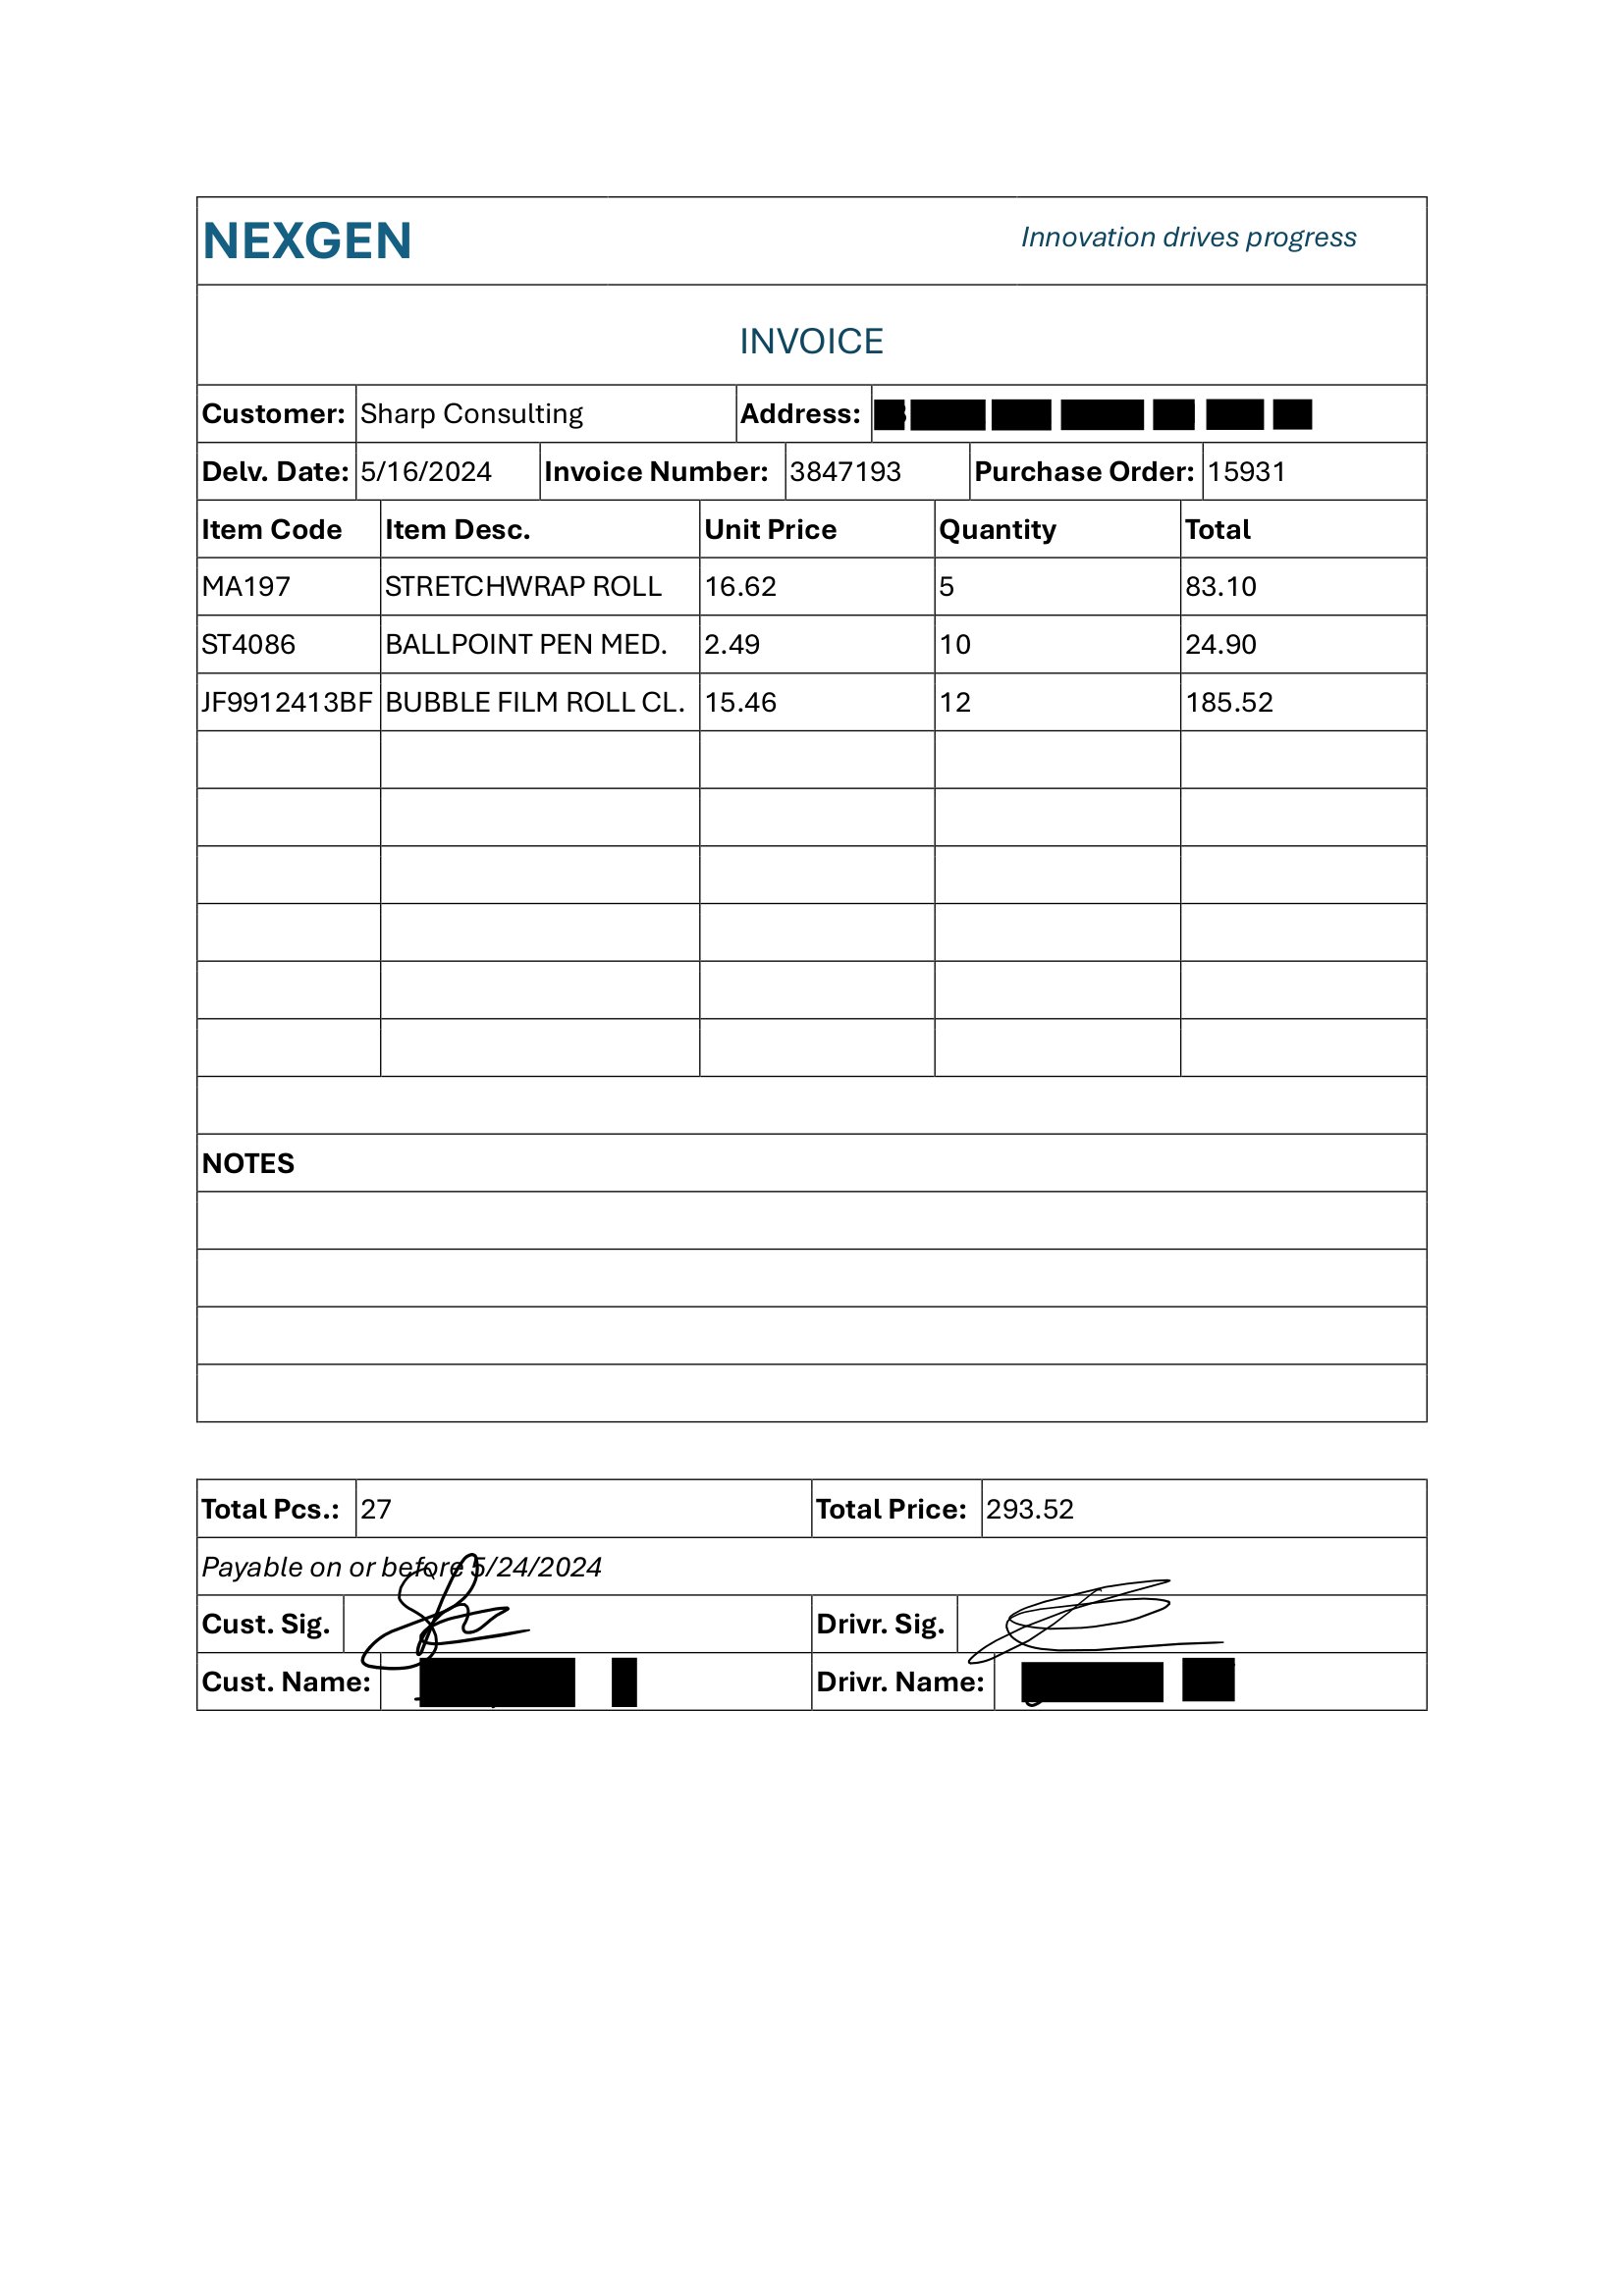


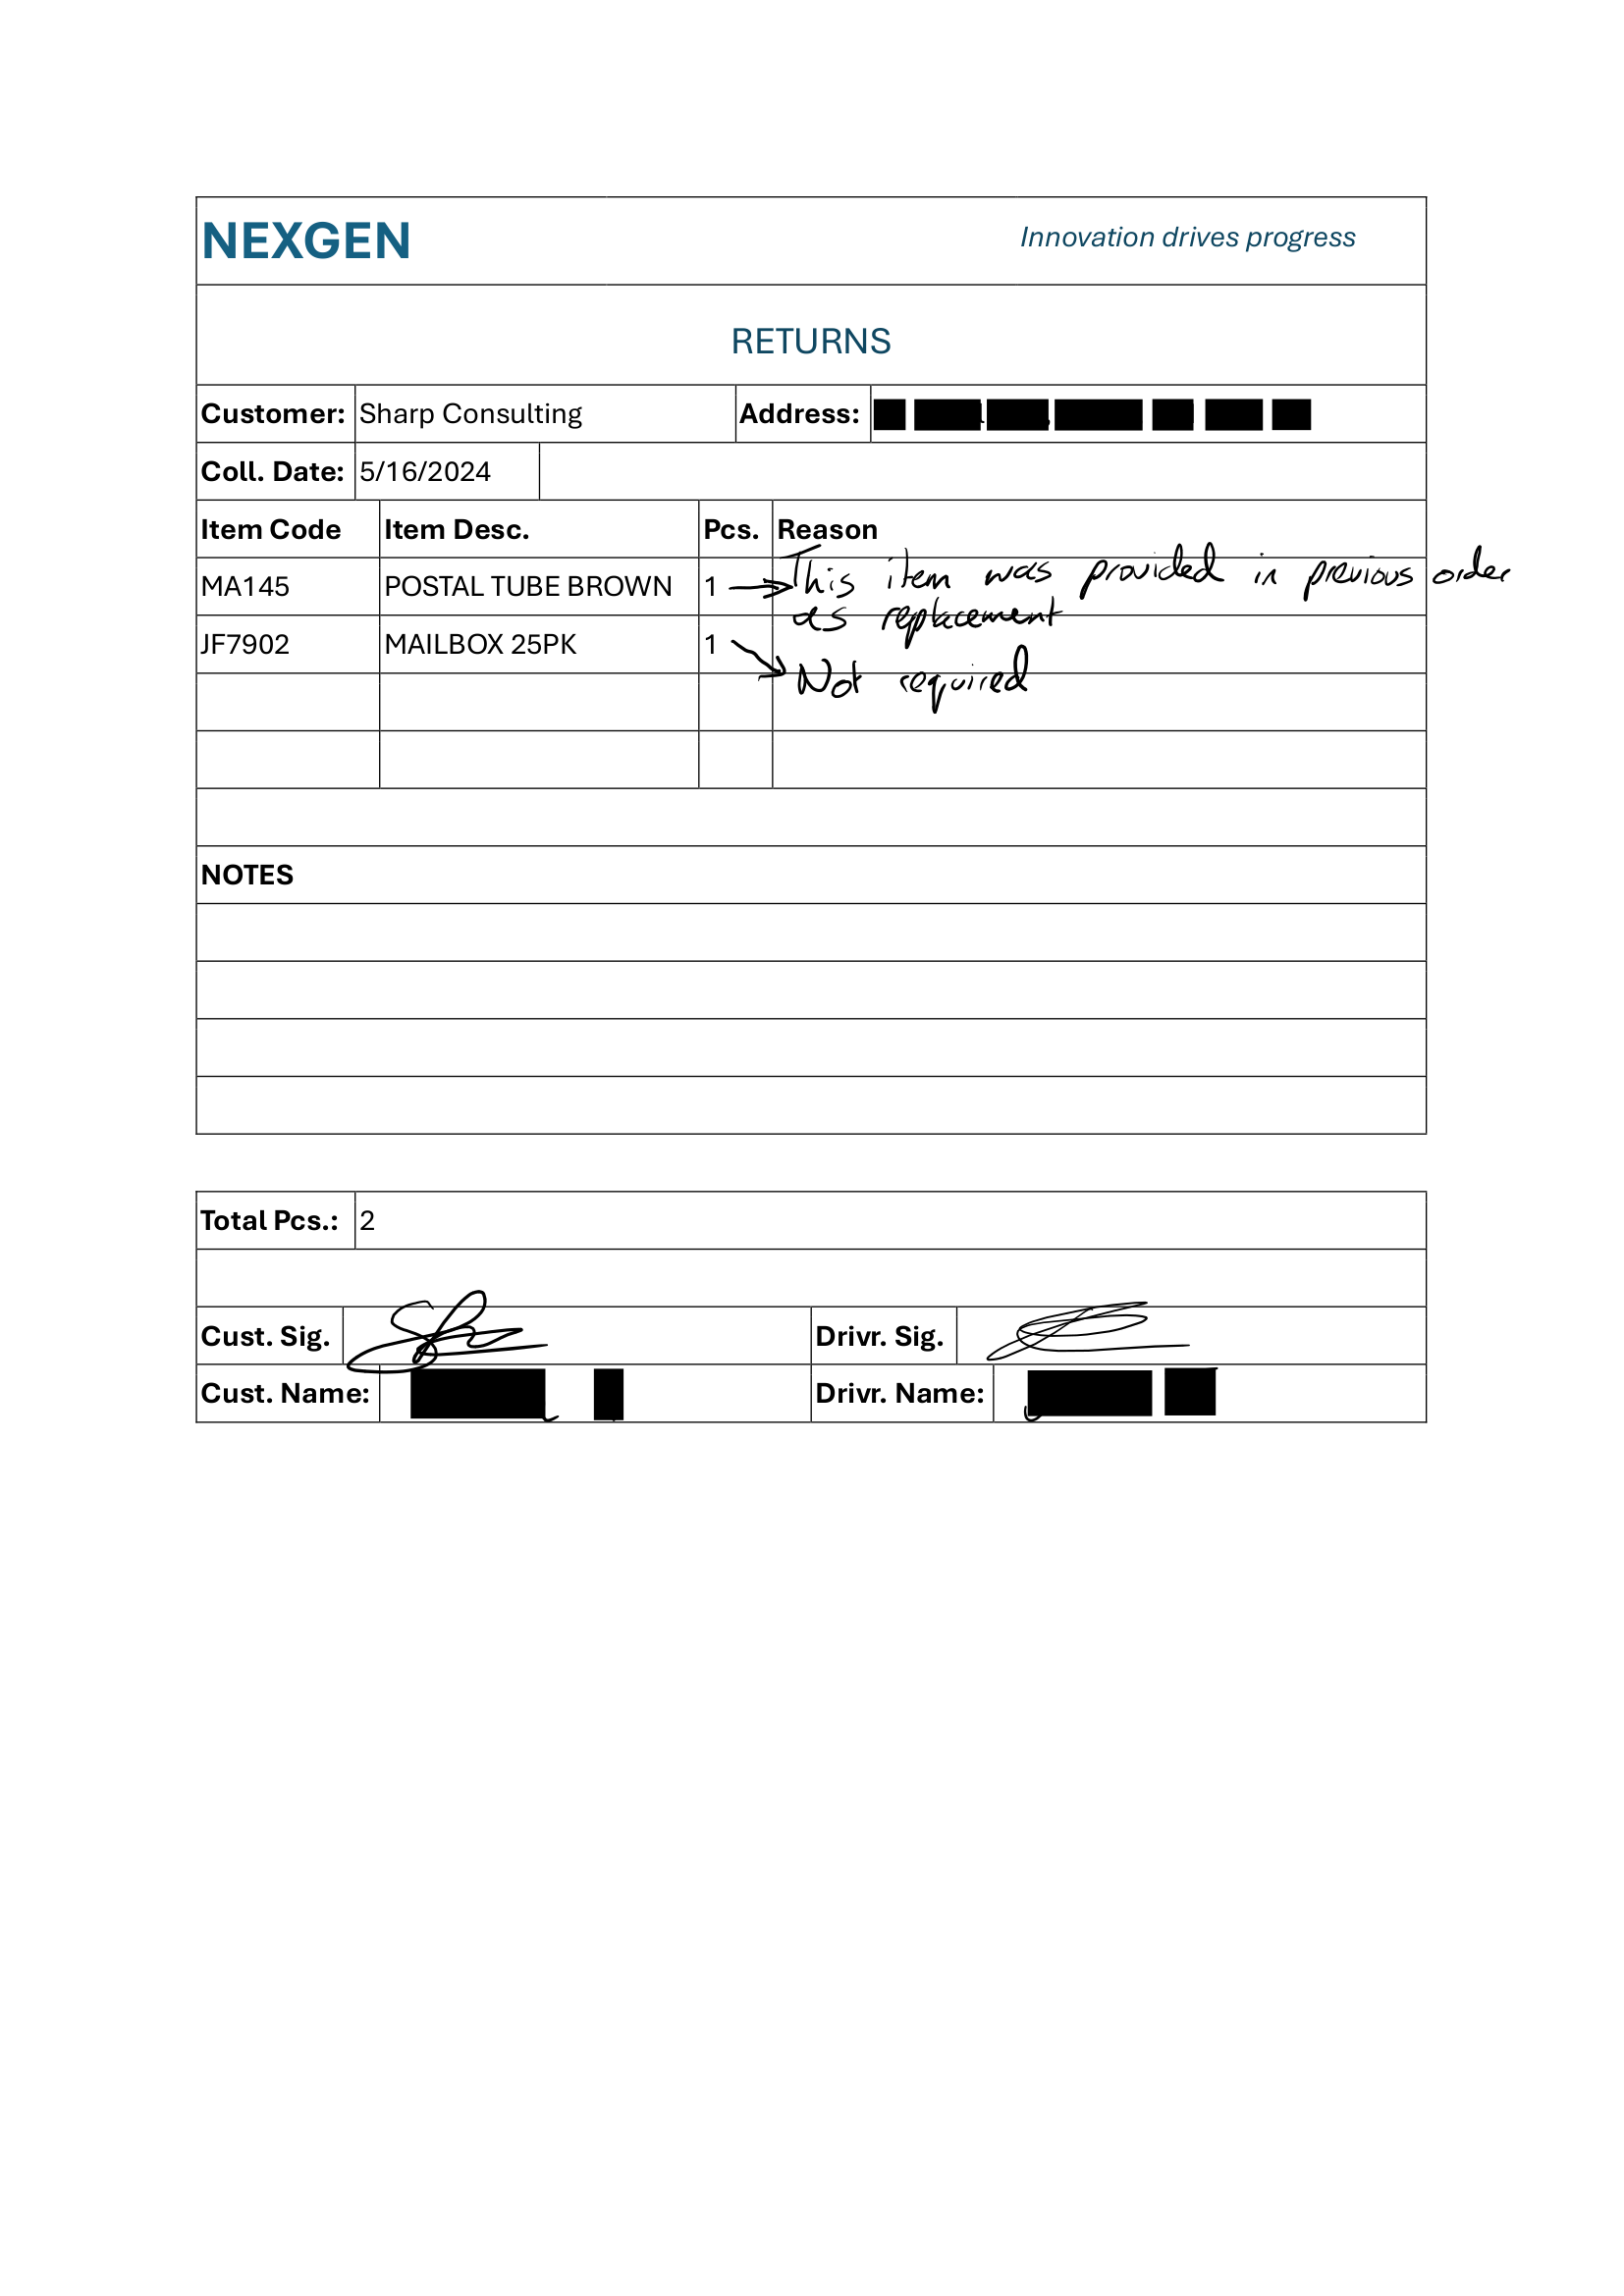

In [ ]:
// Save the redacted images as a new PDF
var redactedPdfFPath = Path.Combine(samplePath, $"{sampleName}_redacted_{pdfFName}");

using (var pdfStream = new SKFileWStream(redactedPdfFPath))
using (var pdfDocument = SKDocument.CreatePdf(pdfStream))
{
    foreach (var redactedPageImage in redactedPageImages)
    {
        using var input = new SKMemoryStream(redactedPageImage);
        using var bitmap = SKBitmap.Decode(input);

        using var canvas = pdfDocument.BeginPage(bitmap.Width, bitmap.Height);
        canvas.DrawBitmap(bitmap, 0, 0);
        pdfDocument.EndPage();
    }
    pdfDocument.Close();
}

// Display the redacted page images
foreach (var redactedPageImage in redactedPageImages)
{
    // Render and display the redacted page images
    var redactedPageImageStream = new SKMemoryStream(redactedPageImage);
    var redactedPageImageBitmap = SKBitmap.Decode(redactedPageImageStream);

    display(redactedPageImageBitmap);
}